### Imports

In [1]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import pyinstrument
import pandas as pd
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
from datetime import datetime, timedelta

In [2]:
file_path = "../data/rents_returns_by_bike_Dresden_01-03.24.pkl"
df = pd.read_pickle(file_path)

# define tools

In [3]:
from datetime import datetime
import pyreadr


def get_filename(time):
    return f'../data/Dresden_01-03.24/{time.strftime("%Y-%m-%d")}/{time.strftime("%Y-%m-%d-%H-%M-00")}.rds'



def import_raw_file(year,month, day, hour, minute, second):
    time = datetime(year,month, day, hour, minute, second)
    current_filename = get_filename(time)
    df = pyreadr.read_r(current_filename)[None]
    return df


# Explore anomalies

In [4]:
df.head()

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
64361,2024-01-21 15:39:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003,rent,2024-01-21,2024-01-21 15:39:00,2024-01-21 15:00:00
486104,2024-01-21 15:46:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003,returns,2024-01-21,2024-01-21 15:46:00,2024-01-21 15:00:00
64421,2024-01-21 15:50:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003,rent,2024-01-21,2024-01-21 15:50:00,2024-01-21 15:00:00
486217,2024-01-21 16:09:00,930000,True,348898836,51.033422,13.707902,NaN,<NA>,returns,2024-01-21,2024-01-21 16:09:00,2024-01-21 16:00:00
64591,2024-01-21 16:31:00,930000,True,348900901,51.033556,13.708078,NaN,<NA>,rent,2024-01-21,2024-01-21 16:31:00,2024-01-21 16:00:00


# datetime_counts

In [5]:
datetime_counts = df.groupby("datetime").rent_or_return.value_counts().unstack(fill_value=0)

In [6]:
datetime_counts.columns

Index(['rent', 'returns'], dtype='object', name='rent_or_return')

In [7]:
datetime_counts

rent_or_return,rent,returns
datetime,,
2024-01-01 00:03:00,1,0
2024-01-01 00:04:00,1,0
2024-01-01 00:05:00,1,0
2024-01-01 00:06:00,1,0
2024-01-01 00:07:00,1,0
...,...,...
2024-03-31 23:55:00,3,1
2024-03-31 23:56:00,3,5
2024-03-31 23:57:00,8,3


In [8]:
datetime_counts = datetime_counts.sort_values("rent", ascending=False)

In [9]:
datetime_counts.head(10)

rent_or_return,rent,returns
datetime,,
2024-02-14 00:40:00,182,0
2024-02-14 00:14:00,148,0
2024-02-13 23:36:00,120,4
2024-02-14 01:07:00,101,0
2024-02-14 08:00:00,93,79
2024-02-14 08:08:00,84,5
2024-02-14 07:58:00,80,6
2024-02-14 08:02:00,69,80
2024-02-13 23:37:00,69,0


In [10]:
datetime_counts = datetime_counts.sort_values("returns", ascending=False)

In [11]:
datetime_counts.head(10)
# too many bikes returned at 2024-02-14 00:27:00

rent_or_return,rent,returns
datetime,,
2024-02-14 00:27:00,1,173
2024-02-14 01:20:00,0,110
2024-02-14 08:10:00,2,85
2024-02-14 08:02:00,69,80
2024-02-14 08:00:00,93,79
2024-02-13 23:52:00,3,71
2024-02-14 00:55:00,0,67
2024-02-12 22:54:00,0,65
2024-02-14 08:01:00,49,61


In [12]:
tmp = datetime_counts.query("(rent > 50) or (returns > 50)").sort_index()

In [55]:
tmp

rent_or_return,rent,returns
datetime,,
2024-02-12 22:54:00,0,65
2024-02-13 23:36:00,120,4
2024-02-13 23:37:00,69,0
2024-02-13 23:51:00,3,60
2024-02-13 23:52:00,3,71
...,...,...
2024-02-14 08:03:00,0,59
2024-02-14 08:08:00,84,5
2024-02-14 08:10:00,2,85


In [13]:
df.columns

Index(['time_stamp', 'bike_number', 'bike', 'uid', 'lat', 'lng', 'name',
       'station_number', 'rent_or_return', 'date', 'datetime',
       'datetime_hour'],
      dtype='object')

# explore strange time period 14th Feb 40 and 27 min

In [14]:
start = datetime(2024, 2, 14, 0, 27, 0)
end = datetime(2024, 2, 14, 0, 40, 0)

In [15]:
df[(df.datetime_hour>=start)]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
172010,2024-02-14 12:22:00,930000,True,360543948,51.080942,13.695018,NaN,<NA>,rent,2024-02-14,2024-02-14 12:22:00,2024-02-14 12:00:00
594658,2024-02-14 14:18:00,930000,False,44177654,51.028416,13.747918,Wundtstraße,43064,returns,2024-02-14,2024-02-14 14:18:00,2024-02-14 14:00:00
174342,2024-02-14 19:03:00,930000,False,44177654,51.028416,13.747918,Wundtstraße,43064,rent,2024-02-14,2024-02-14 19:03:00,2024-02-14 19:00:00
596390,2024-02-14 19:12:00,930000,True,360734273,51.020200,13.764616,NaN,<NA>,returns,2024-02-14,2024-02-14 19:12:00,2024-02-14 19:00:00
187125,2024-02-17 13:55:00,930000,True,362033813,51.020151,13.764691,NaN,<NA>,rent,2024-02-17,2024-02-17 13:55:00,2024-02-17 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
830000,2024-03-28 17:02:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432,returns,2024-03-28,2024-03-28 17:02:00,2024-03-28 17:00:00
407930,2024-03-28 17:34:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432,rent,2024-03-28,2024-03-28 17:34:00,2024-03-28 17:00:00
830216,2024-03-28 17:39:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432,returns,2024-03-28,2024-03-28 17:39:00,2024-03-28 17:00:00
408412,2024-03-28 18:42:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432,rent,2024-03-28,2024-03-28 18:42:00,2024-03-28 18:00:00


In [16]:
df.columns

Index(['time_stamp', 'bike_number', 'bike', 'uid', 'lat', 'lng', 'name',
       'station_number', 'rent_or_return', 'date', 'datetime',
       'datetime_hour'],
      dtype='object')

In [17]:
df_anomaly = df[(df.datetime==start) | (df.datetime==end)][["datetime", "bike_number", "rent_or_return", "name", "uid", "lat", "lng"]]

In [18]:
df_anomaly = df_anomaly.sort_values(["bike_number", "datetime"])

In [19]:
start_bikes = set(df[df.datetime==start].bike_number)

In [20]:
end_bikes = set(df[df.datetime==end].bike_number)

In [21]:
len(start_bikes)

174

In [22]:
len(end_bikes)

182

In [23]:
len(start_bikes-end_bikes)

172

In [24]:
len(end_bikes-start_bikes)

180

In [25]:
# looks like bikes were replaces by new ones ... or renamed? or is everything normal?

In [26]:
df_start = import_raw_file(2024, 2, 14, 0, 27, 0)

In [27]:
df_end = import_raw_file(2024, 2, 14, 0, 40, 0)

In [28]:
len(set(df_end.bike_number))

1346

In [29]:
len(set(df_end.boardcomputer))

1346

In [30]:
len(set(df_start.boardcomputer))

1334

In [31]:
len(set(df_start.bike_number))

1334

In [32]:
len(set(df_start.boardcomputer)-set(df_end.boardcomputer))

8

In [33]:
len(set(df_end.boardcomputer)-set(df_start.boardcomputer))

20

In [34]:
len(set(df_start.bike_number)-set(df_end.bike_number))

8

In [35]:
len(set(df_end.bike_number)-set(df_start.bike_number))

20

In [36]:
columns_to_keep = ["time_stamp", "bike_number", "bike", "uid", "lat", "lng", "name", "station_number", "boardcomputer"]
start_time = start
end_time = end

rent_list=[]
return_list=[]

lag_time = start_time - timedelta(minutes=1)
lag_filename = get_filename(lag_time)
df_lag = pyreadr.read_r(lag_filename)[None][columns_to_keep]
lag_bike_numbers = set(df_lag.bike_number)

for current_time in [start, end]:
        current_filename = get_filename(current_time)
        try:
                df_current = pyreadr.read_r(current_filename)[None][columns_to_keep]
                current_bike_numbers = set(df_current.bike_number)

                rented_bikes = df_lag[df_lag.bike_number.isin(lag_bike_numbers-current_bike_numbers)]
                if not rented_bikes.empty:
                        rent_list.extend(rented_bikes.to_dict(orient="records"))

                returned_bikes = df_current[df_current.bike_number.isin(current_bike_numbers-lag_bike_numbers)]
                if not returned_bikes.empty:
                        return_list.extend(returned_bikes.to_dict(orient="records"))
                
                df_lag = df_current
                lag_bike_numbers = current_bike_numbers
        except Exception as e:
                pass

In [37]:
df = pd.DataFrame(rent_list)
df['rent_or_return']="rent"
df_return = pd.DataFrame(return_list)
df_return['rent_or_return']="returns"
df = pd.concat([df,df_return], ignore_index=True)
df = df.sort_values(["bike_number", "time_stamp"])

In [38]:
df

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,boardcomputer,rent_or_return
71,2024-02-14 00:27:00,930027,True,360278982,51.073951,13.723552,NaN,NaN,7.551063e+09,returns
21,2024-02-14 00:27:00,930032,False,218593464,50.997110,13.827580,Prof.-Billroth-Straße,43276.0,7.551060e+09,returns
157,2024-02-14 00:27:00,930045,True,360332310,51.035924,13.731431,NaN,NaN,7.551049e+09,returns
144,2024-02-14 00:27:00,930046,True,360325428,51.069524,13.749404,NaN,NaN,7.551146e+09,returns
87,2024-02-14 00:27:00,930078,True,360288659,51.042236,13.730861,NaN,NaN,7.551172e+09,returns
...,...,...,...,...,...,...,...,...,...,...
1,2024-02-14 00:26:00,931758,False,34123449,51.068942,13.758811,MOBIpunkt Alaunpark,43021.0,7.551153e+09,rent
203,2024-02-14 00:40:00,931758,True,360344911,51.061027,13.750514,NaN,NaN,7.551153e+09,returns
129,2024-02-14 00:27:00,931761,True,360317741,51.038476,13.719103,NaN,NaN,7.551153e+09,returns
183,2024-02-14 00:27:00,931763,True,360339365,51.038142,13.791441,NaN,NaN,7.551155e+09,returns


In [39]:
df.groupby(["time_stamp","rent_or_return"]).size()

time_stamp           rent_or_return
2024-02-14 00:26:00  rent                7
2024-02-14 00:27:00  rent                8
                     returns           173
2024-02-14 00:40:00  returns            20
dtype: int64

In [40]:
df = pd.read_pickle(file_path)

In [41]:
df[(df.datetime==start)&(df.rent_or_return=="returns") ]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
591428,2024-02-14 00:27:00,930027,True,360278982,51.073951,13.723552,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591378,2024-02-14 00:27:00,930032,False,218593464,50.997110,13.827580,Prof.-Billroth-Straße,43276,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591514,2024-02-14 00:27:00,930045,True,360332310,51.035924,13.731431,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591501,2024-02-14 00:27:00,930046,True,360325428,51.069524,13.749404,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591444,2024-02-14 00:27:00,930078,True,360288659,51.042236,13.730861,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
...,...,...,...,...,...,...,...,...,...,...,...,...
591491,2024-02-14 00:27:00,931751,True,360320466,51.038000,13.743923,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591484,2024-02-14 00:27:00,931752,True,360317524,51.046911,13.766332,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591486,2024-02-14 00:27:00,931761,True,360317741,51.038476,13.719103,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14
591540,2024-02-14 00:27:00,931763,True,360339365,51.038142,13.791441,NaN,<NA>,returns,2024-02-14,2024-02-14 00:27:00,2024-02-14


,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
171289,2024-02-14 09:31:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,rent,2024-02-14,2024-02-14 09:31:00,2024-02-14 09:00:00
593305,2024-02-14 09:33:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,returns,2024-02-14,2024-02-14 09:33:00,2024-02-14 09:00:00
171326,2024-02-14 09:39:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,rent,2024-02-14,2024-02-14 09:39:00,2024-02-14 09:00:00
593344,2024-02-14 09:43:00,930009,False,77690732,51.029111,13.728472,StuRa-Baracke,43143,returns,2024-02-14,2024-02-14 09:43:00,2024-02-14 09:00:00
172631,2024-02-14 14:14:00,930009,False,77690732,51.029111,13.728472,StuRa-Baracke,43143,rent,2024-02-14,2024-02-14 14:14:00,2024-02-14 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
405503,2024-03-28 10:53:00,930009,True,382830853,51.047284,13.737177,NaN,<NA>,rent,2024-03-28,2024-03-28 10:53:00,2024-03-28 10:00:00
827794,2024-03-28 10:56:00,930009,True,382833096,51.047369,13.736960,NaN,<NA>,returns,2024-03-28,2024-03-28 10:56:00,2024-03-28 10:00:00
405927,2024-03-28 12:13:00,930009,True,382835233,51.047364,13.736957,NaN,<NA>,rent,2024-03-28,2024-03-28 12:13:00,2024-03-28 12:00:00
405963,2024-03-28 12:21:00,930009,True,382867235,51.042636,13.751184,NaN,<NA>,rent,2024-03-28,2024-03-28 12:21:00,2024-03-28 12:00:00


# date_counts

In [43]:
date_counts = df.groupby("date").rent_or_return.value_counts().unstack(fill_value=0)

In [57]:
date_counts

rent_or_return,rent,returns
date,,
2024-01-01,2611,2586
2024-01-02,2059,2012
2024-01-03,4049,3961
2024-01-04,3680,3634
2024-01-05,4747,4740
...,...,...
2024-03-27,6253,6273
2024-03-28,5794,5787
2024-03-29,3709,3704


In [60]:
date_counts.sort_values("rent", ascending=False).head(10)

rent_or_return,rent,returns
date,,
2024-03-01,14046,13949
2024-03-22,13703,13608
2024-02-02,13014,12921
2024-03-02,10944,10901
2024-03-27,6253,6273
2024-03-15,6240,6266
2024-02-14,6116,6086
2024-03-26,5920,5881
2024-03-13,5840,5866


<Axes: xlabel='date'>

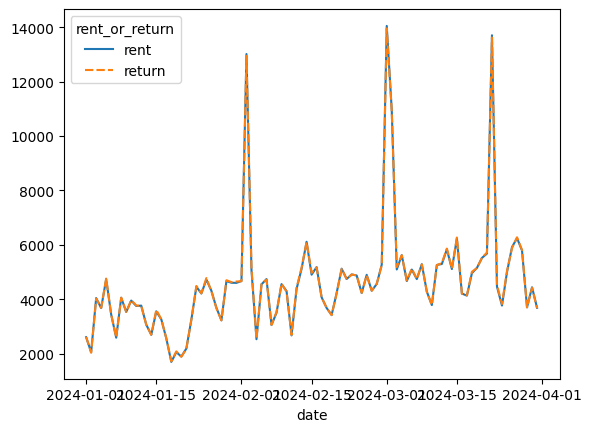

In [ ]:
sns.lineplot(date_counts)

# hour_counts

In [45]:
hour_counts = df.groupby("datetime_hour").rent_or_return.value_counts().unstack(fill_value=0)

<Axes: xlabel='datetime_hour'>

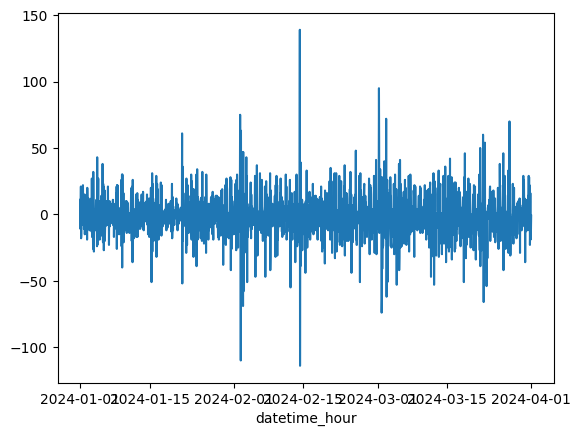

In [ ]:
sns.lineplot(hour_counts.rent-hour_counts["return"])

In [ ]:
hourly_diffs = hour_counts.rent-hour_counts["returns"]

In [ ]:
hourly_diffs.sort_values()

datetime_hour
2024-02-02 09:00:00    -98
2024-02-14 08:00:00    -92
2024-03-01 19:00:00    -74
2024-02-02 20:00:00    -69
2024-03-22 09:00:00    -66
                      ... 
2024-03-27 14:00:00     70
2024-03-02 17:00:00     72
2024-02-02 06:00:00     75
2024-03-01 06:00:00     95
2024-02-14 07:00:00    139
Length: 2184, dtype: int64

In [ ]:
hour_counts.query("'rent'-'return'>100")

TypeError: unsupported operand type(s) for -: 'str' and 'str'

<Axes: xlabel='datetime_hour'>

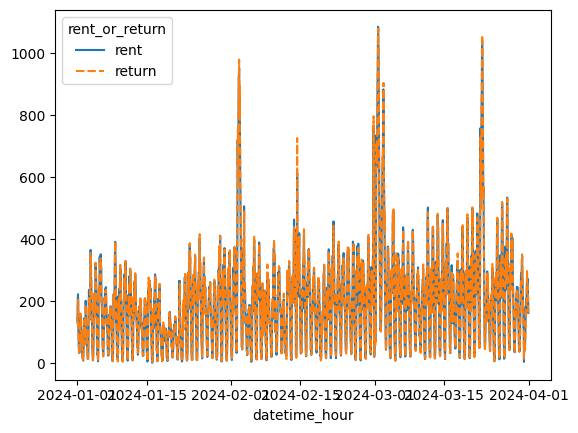

In [ ]:
sns.lineplot(hour_counts)

# unique bikes
bikes get added and excluded throughout the timeline

In [46]:
jan_bikes = set(df[df.datetime.dt.month==1].bike_number.unique())
feb_bikes = set(df[df.datetime.dt.month==2].bike_number.unique())
mar_bikes = set(df[df.datetime.dt.month==3].bike_number.unique())

In [47]:
len(feb_bikes-jan_bikes)

214

In [48]:
len(jan_bikes)

1475

In [61]:
len(feb_bikes-jan_bikes)

214

In [62]:
len(jan_bikes-feb_bikes)

59

In [51]:
df.datetime.dt.month

64361     1
486104    1
64421     1
486217    1
64591     1
         ..
830000    3
407930    3
830216    3
408412    3
830713    3
Name: datetime, Length: 843014, dtype: int32

In [ ]:
len(df.bike_number.unique())

1860

# daatetime_counts

In [ ]:
datetime_counts = df.groupby("datetime").size()
datetime_counts = datetime_counts.sort_values(ascending=False)

In [ ]:
datetime_counts.head(10)

datetime
2024-02-14 00:40:00    182
2024-02-14 00:27:00    174
2024-02-14 08:00:00    172
2024-02-14 08:02:00    149
2024-02-14 00:14:00    148
2024-02-13 23:36:00    124
2024-02-14 01:20:00    110
2024-02-14 08:01:00    110
2024-02-14 01:07:00    101
2024-02-14 08:08:00     89
dtype: int64

In [ ]:
datetime_counts.reset_index

AttributeError: 'Series' object has no attribute 'datetime'

In [ ]:
df.datetime

481181   2024-01-19 08:43:00
64361    2024-01-21 15:39:00
486104   2024-01-21 15:46:00
64421    2024-01-21 15:50:00
486217   2024-01-21 16:09:00
                 ...        
830000   2024-03-28 17:02:00
407930   2024-03-28 17:34:00
830216   2024-03-28 17:39:00
408412   2024-03-28 18:42:00
830713   2024-03-28 18:50:00
Name: datetime, Length: 843909, dtype: datetime64[ns]

In [ ]:
datetime_counts.tail(10)

time_stamp
2024-03-22 03:09:00    1
2024-03-22 03:13:00    1
2024-03-22 03:18:00    1
2024-03-22 03:21:00    1
2024-02-06 08:20:00    1
2024-01-16 22:54:00    1
2024-01-14 09:07:00    1
2024-01-14 09:09:00    1
2024-02-13 00:37:00    1
2024-02-13 00:38:00    1
dtype: int64

In [ ]:
len(df)-len(df.drop_duplicates())

0

In [ ]:
df

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date
481181,2024-01-19 08:43:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,return,2024-01-19
64361,2024-01-21 15:39:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,rent,2024-01-21
486104,2024-01-21 15:46:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,return,2024-01-21
64421,2024-01-21 15:50:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,rent,2024-01-21
486217,2024-01-21 16:09:00,930000,True,348898836,51.033422,13.707902,NaN,NaN,return,2024-01-21
...,...,...,...,...,...,...,...,...,...,...
830000,2024-03-28 17:02:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,return,2024-03-28
407930,2024-03-28 17:34:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,rent,2024-03-28
830216,2024-03-28 17:39:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,return,2024-03-28
408412,2024-03-28 18:42:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,rent,2024-03-28


# individual bike checks

In [ ]:
df[df.bike_number==931492]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
79,2024-01-31 01:56:00,931492,False,55466724,51.029253,13.730582,Hörsaalzentrum TU Dresden,43116.0,rent


In [ ]:
df[df.bike_number==931492]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
79,2024-01-31 01:56:00,931492,False,55466724,51.029253,13.730582,Hörsaalzentrum TU Dresden,43116.0,rent


In [ ]:
df[df.bike_number==930494]  

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
78,2024-01-31 01:47:00,930494,True,353304968,51.070476,13.747492,NaN,NaN,rent
166,2024-01-31 01:57:00,930494,True,353375953,51.057511,13.724396,NaN,NaN,return


In [ ]:
df[df.bike_number==930494]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
78,2024-01-31 01:47:00,930494,True,353304968,51.070476,13.747492,NaN,NaN,rent
166,2024-01-31 01:57:00,930494,True,353375953,51.057511,13.724396,NaN,NaN,return


In [63]:
df[df.bike_number==930009].sort_values("datetime")

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
171289,2024-02-14 09:31:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,rent,2024-02-14,2024-02-14 09:31:00,2024-02-14 09:00:00
593305,2024-02-14 09:33:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,returns,2024-02-14,2024-02-14 09:33:00,2024-02-14 09:00:00
171326,2024-02-14 09:39:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,rent,2024-02-14,2024-02-14 09:39:00,2024-02-14 09:00:00
593344,2024-02-14 09:43:00,930009,False,77690732,51.029111,13.728472,StuRa-Baracke,43143,returns,2024-02-14,2024-02-14 09:43:00,2024-02-14 09:00:00
172631,2024-02-14 14:14:00,930009,False,77690732,51.029111,13.728472,StuRa-Baracke,43143,rent,2024-02-14,2024-02-14 14:14:00,2024-02-14 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
405503,2024-03-28 10:53:00,930009,True,382830853,51.047284,13.737177,NaN,<NA>,rent,2024-03-28,2024-03-28 10:53:00,2024-03-28 10:00:00
827794,2024-03-28 10:56:00,930009,True,382833096,51.047369,13.736960,NaN,<NA>,returns,2024-03-28,2024-03-28 10:56:00,2024-03-28 10:00:00
405927,2024-03-28 12:13:00,930009,True,382835233,51.047364,13.736957,NaN,<NA>,rent,2024-03-28,2024-03-28 12:13:00,2024-03-28 12:00:00
405963,2024-03-28 12:21:00,930009,True,382867235,51.042636,13.751184,NaN,<NA>,rent,2024-03-28,2024-03-28 12:21:00,2024-03-28 12:00:00
